In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from model import VisionTransformer, ViTConfig

from utils import VideoFolder, transforms_testing, mixup_cutmix_collate_func, transform_inference
from torch.utils.data import DataLoader 

from safetensors.torch import load_file

In [52]:
CLIP_LOC = 'data/test'
N_FRAMES = 18
IMG_WH = 224
WEIGHTS_LOC = 'work_dir/ViT_LoRA_Temporal_UCF101_Training/checkpoints/checkpoint_merged_fin.safetensors'

test_transforms = transforms_testing(img_wh=IMG_WH)
inference_transforms = transform_inference(img_wh=IMG_WH)
test_data = VideoFolder(path_to_data=CLIP_LOC, 
                        frames_n=N_FRAMES,
                        transform=test_transforms)
test_data_vis = VideoFolder(path_to_data=CLIP_LOC,
                            frames_n=N_FRAMES,
                            transform=inference_transforms)
# range_n = range(len(test_data))
# sampler = SubsetRandomSampler(range_n)
perm = torch.randperm(len(test_data))
num_classes = len(test_data.idx2class.keys())
collate_fn = mixup_cutmix_collate_func()
test_loader = DataLoader(test_data, collate_fn=collate_fn, sampler=perm)
test_loader_vis = DataLoader(test_data_vis, collate_fn=collate_fn, sampler=perm)

test_loader_iterable = iter(test_loader)
test_loader_vis_iterable = iter(test_loader_vis)

In [48]:
config = ViTConfig(n_frames=18,
                   num_classes=num_classes)
model = VisionTransformer(config)
state_dict = load_file(WEIGHTS_LOC)

model.load_state_dict(state_dict)

print(model)

VisionTransformer(
  (patch_embd): PatchEmbedding(
    (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (q): Linear(in_features=768, out_features=768, bias=True)
        (k): Linear(in_features=768, out_features=768, bias=True)
        (v): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_dropout): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (activation_f): GELU(approximate='none')
        (dropout1): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features

In [49]:
def generate_plots(frames, ax, dim=3):
    for i in range(0,dim):
        for j in range(0,dim):
            ax[i,j].imshow(frames[i*dim+j].permute(1,2,0))
            
    plt.show() 

Label: BenchPress - BenchPress


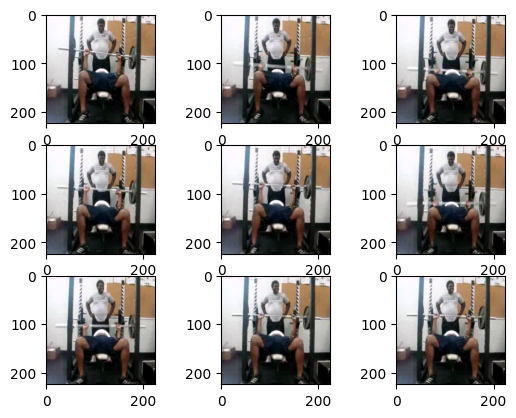

Predicted values:
Top 1: BenchPress
Top 5: ['BenchPress', 'BodyWeightSquats', 'PullUps', 'PlayingCello', 'WallPushups']


In [58]:
idx2class = test_data.idx2class
with torch.no_grad():
    data = next(test_loader_iterable)
    data_vis = next(test_loader_vis_iterable)
    frames, lbl = data
    frames_vis, lbl_vis = data_vis
    
    print(f'Label: {idx2class[lbl.item()]} - {idx2class[lbl_vis.item()]}')
    dim=3 
    fig, ax = plt.subplots(dim, dim)
    generate_plots(frames_vis.squeeze(0), ax, dim=dim)
    
    output = model(frames)
    
    probs = F.softmax(output, dim=-1)
    k = 5
    values, idxs = probs.topk(k=1, dim=-1)
    values_topk, idxs_topk = probs.topk(k=k, dim=-1)

    
    print('Predicted values:')
    print(f'Top 1: {idx2class[idxs.squeeze(0).item()]}')
    print(f'Top {k}: {[idx2class[idx] for idx in idxs_topk.squeeze(0).tolist()]}')
    